# xLSTM for IMDB Sentiment Classification

This notebook explores the **Extended LSTM (xLSTM)** architecture from [Beck et al. (2024)](https://arxiv.org/abs/2405.04517) for sentiment classification. We compare two variants:

1. **mLSTM** (matrix LSTM): Uses a matrix memory and covariance update rule, excels at memorization tasks
2. **sLSTM** (scalar LSTM): Traditional LSTM with exponential gating, better for state-tracking tasks

Both models use learnable embeddings trained from scratch.

**Reference**: [NX-AI/xlstm](https://github.com/NX-AI/xlstm)


## 1. Setup and Imports


In [9]:
# Install xLSTM if needed
# !pip install xlstm


In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from utils_torch import (
    load_imdb_data_torch,
    create_dataloaders,
    LSTMClassifier,
    mLSTMClassifier,
    sLSTMClassifier,
    train_model,
    eval_binary_classification_torch,
    plot_training_history,
    compare_models
)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [11]:
# Hyperparameters
MAX_WORDS = 10000      # Vocabulary size
MAX_LEN = 256          # Sequence length (shorter for xLSTM memory efficiency)
EMBEDDING_DIM = 128    # Embedding dimension (must be divisible by num_heads)
NUM_HEADS = 4          # Number of attention heads for xLSTM
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-3


## 2. Load IMDB Dataset


In [12]:
# Load data as PyTorch tensors
X_train, y_train, X_val, y_val, X_test, y_test, word_index = load_imdb_data_torch(
    num_words=MAX_WORDS,
    maxlen=MAX_LEN,
    test_split=0.5
)


Training samples:   25,000
Validation samples: 12,500
Test samples:       12,500
Vocabulary size:    10,000
Sequence length:    256


In [13]:
# Create DataLoaders
train_loader, val_loader = create_dataloaders(
    X_train, y_train, X_val, y_val, batch_size=BATCH_SIZE
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Training batches: 782
Validation batches: 391


## 3. Model 1: mLSTM (Matrix LSTM)

The **mLSTM** variant uses:
- Matrix-valued memory state (instead of vector)
- Covariance update rule
- Exponential gating with normalization

This provides excellent **memorization capabilities** - useful for tasks requiring retrieval of information from long sequences.


In [14]:
# Create mLSTM model with learnable embeddings
model_mlstm = mLSTMClassifier(
    vocab_size=MAX_WORDS,
    embedding_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    padding_idx=0
)

# Count parameters
total_params = sum(p.numel() for p in model_mlstm.parameters())
trainable_params = sum(p.numel() for p in model_mlstm.parameters() if p.requires_grad)
print(f"mLSTM Model:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")


mLSTM Model:
  Total parameters: 1,389,705
  Trainable parameters: 1,389,705


In [15]:
# Train mLSTM model
print("Training mLSTM model...")
print("=" * 60)

history_mlstm = train_model(
    model=model_mlstm,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=3
)


Training mLSTM model...
Epoch 1/10 - Loss: 0.5462 - Acc: 0.6976 - Val Loss: 0.3930 - Val Acc: 0.8291
Epoch 2/10 - Loss: 0.2654 - Acc: 0.8936 - Val Loss: 0.3574 - Val Acc: 0.8560
Epoch 3/10 - Loss: 0.1261 - Acc: 0.9544 - Val Loss: 0.4384 - Val Acc: 0.8436
Epoch 4/10 - Loss: 0.0630 - Acc: 0.9783 - Val Loss: 0.5546 - Val Acc: 0.8437
Epoch 5/10 - Loss: 0.0369 - Acc: 0.9878 - Val Loss: 0.6045 - Val Acc: 0.8514
Early stopping at epoch 5


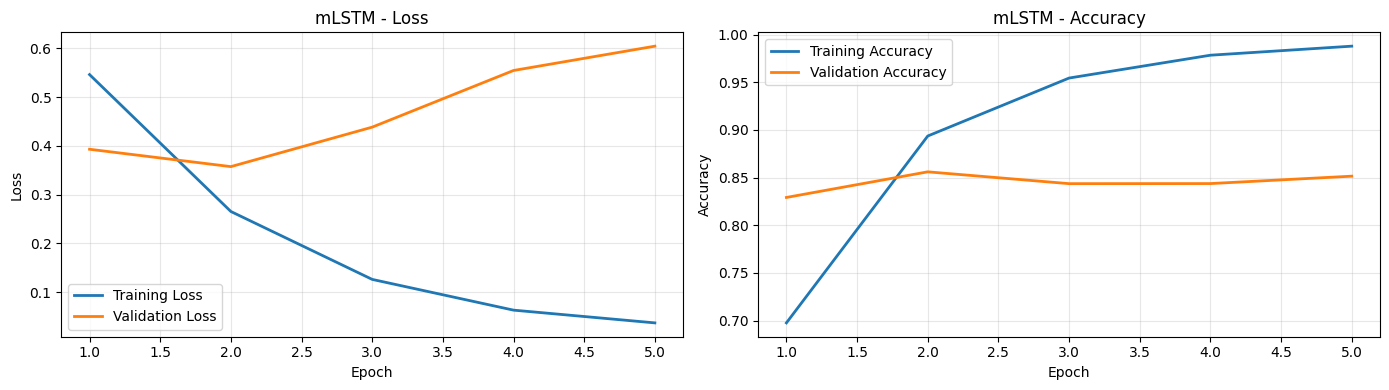

In [16]:
# Plot mLSTM training history
plot_training_history(history_mlstm, title="mLSTM")


## 4. Model 2: sLSTM (Scalar LSTM)

The **sLSTM** variant uses:
- Traditional scalar memory cells
- Exponential gating (improved over standard LSTM sigmoid gates)
- Memory mixing between heads

This excels at **state-tracking tasks** - useful when the model needs to maintain and update internal state over time.


In [17]:
# Create sLSTM model with learnable embeddings
# Note: Use backend="vanilla" for CPU or older GPUs
# Use backend="cuda" for NVIDIA GPUs with Compute Capability >= 8.0
model_slstm = sLSTMClassifier(
    vocab_size=MAX_WORDS,
    embedding_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    padding_idx=0,
    backend="vanilla"  # Change to "cuda" if you have compatible GPU
)

# Count parameters
total_params = sum(p.numel() for p in model_slstm.parameters())
trainable_params = sum(p.numel() for p in model_slstm.parameters() if p.requires_grad)
print(f"sLSTM Model:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")


sLSTM Model:
  Total parameters: 1,388,289
  Trainable parameters: 1,388,289


In [18]:
# Train sLSTM model
print("Training sLSTM model...")
print("=" * 60)

history_slstm = train_model(
    model=model_slstm,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=3
)


Training sLSTM model...
Epoch 1/10 - Loss: 0.5715 - Acc: 0.6748 - Val Loss: 0.4384 - Val Acc: 0.8013
Epoch 2/10 - Loss: 0.3300 - Acc: 0.8570 - Val Loss: 0.3520 - Val Acc: 0.8473
Epoch 3/10 - Loss: 0.2283 - Acc: 0.9078 - Val Loss: 0.3430 - Val Acc: 0.8574
Epoch 4/10 - Loss: 0.1635 - Acc: 0.9368 - Val Loss: 0.3631 - Val Acc: 0.8631


KeyboardInterrupt: 

In [ ]:
# Plot sLSTM training history
plot_training_history(history_slstm, title="sLSTM")


## 5. Baseline: Standard LSTM

For comparison, we also train a standard PyTorch LSTM.


In [ ]:
# Create standard LSTM model
model_lstm = LSTMClassifier(
    vocab_size=MAX_WORDS,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=EMBEDDING_DIM,  # Same dimension for fair comparison
    padding_idx=0
)

# Count parameters
total_params = sum(p.numel() for p in model_lstm.parameters())
trainable_params = sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)
print(f"Standard LSTM Model:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")


In [ ]:
# Train standard LSTM
print("Training standard LSTM model...")
print("=" * 60)

history_lstm = train_model(
    model=model_lstm,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=3
)


In [ ]:
# Plot standard LSTM training history
plot_training_history(history_lstm, title="Standard LSTM")


## 6. Evaluate on Hold-out Test Set


In [ ]:
# Evaluate mLSTM
print("=" * 70)
print("EVALUATING mLSTM")
print("=" * 70)
loss_mlstm, acc_mlstm = eval_binary_classification_torch(
    model_mlstm, X_test, y_test, device,
    model_name="mLSTM"
)


In [ ]:
# Evaluate sLSTM
print("=" * 70)
print("EVALUATING sLSTM")
print("=" * 70)
loss_slstm, acc_slstm = eval_binary_classification_torch(
    model_slstm, X_test, y_test, device,
    model_name="sLSTM"
)


In [ ]:
# Evaluate standard LSTM
print("=" * 70)
print("EVALUATING STANDARD LSTM")
print("=" * 70)
loss_lstm, acc_lstm = eval_binary_classification_torch(
    model_lstm, X_test, y_test, device,
    model_name="Standard LSTM"
)


## 7. Model Comparison


In [ ]:
# Compare all models
results = {
    "mLSTM": (loss_mlstm, acc_mlstm),
    "sLSTM": (loss_slstm, acc_slstm),
    "Standard LSTM": (loss_lstm, acc_lstm)
}
compare_models(results)


In [ ]:
# Summary table
summary_df = pd.DataFrame({
    'Model': ['mLSTM', 'sLSTM', 'Standard LSTM'],
    'Test Loss': [loss_mlstm, loss_slstm, loss_lstm],
    'Test Accuracy': [f"{acc_mlstm*100:.2f}%", f"{acc_slstm*100:.2f}%", f"{acc_lstm*100:.2f}%"],
    'Parameters': [
        f"{sum(p.numel() for p in model_mlstm.parameters()):,}",
        f"{sum(p.numel() for p in model_slstm.parameters()):,}",
        f"{sum(p.numel() for p in model_lstm.parameters()):,}"
    ]
})
summary_df


## 8. Key Differences: mLSTM vs sLSTM

| Feature | mLSTM | sLSTM |
|---------|-------|-------|
| Memory | Matrix-valued (d × d) | Scalar (vector) |
| Update Rule | Covariance update | Traditional LSTM-style |
| Gating | Exponential | Exponential |
| Memory Mixing | No | Yes (between heads) |
| Best For | Memorization, retrieval | State tracking, reasoning |
| Parallelizable | Yes | Limited |

### When to use which?

- **mLSTM**: When you need to store and retrieve information from long sequences (e.g., document QA)
- **sLSTM**: When you need to track and update state over time (e.g., parity checking, counting)
- **Combined (xLSTM)**: For general-purpose tasks, alternate mLSTM and sLSTM blocks


## References

- Beck, M., et al. (2024). [xLSTM: Extended Long Short-Term Memory](https://arxiv.org/abs/2405.04517). NeurIPS 2024.
- GitHub: [NX-AI/xlstm](https://github.com/NX-AI/xlstm)
